# Headphones v Speakers EMG, Balance, Breathing Data

## Installing and importing libraries

In [1]:
# Install pip packages in the current Jupyter kernel
import sys

In [ ]:
import pandas as pd
import numpy as np

import matplotlib

%matplotlib inline

import matplotlib.pyplot as plt

import math

import sys

import pylab

import numpy.linalg

import plotly as py

%load_ext rpy2.ipython

#r packages
from rpy2.robjects import r
from rpy2.robjects.packages import importr
from rpy2.robjects import FloatVector
stats = importr('stats')
base = importr('base')

from scipy import stats

import seaborn

from IPython.display import display, Markdown

## Delsys EMG Data

### Reading EMG csv files for all participants
Each Delsys Trigno sensor collects data through four channels: EMG, AccX, AccY, AccZ. We're only interested in EMG data from each sensor.

Sensors were attached to Left Upper Trapezius, Right Upper Trapezius, Left Arm Flexor Digitorum, Right Arm Flexor Digitorum, Left Foot Flexor Digitorum, Right Foot Flexor Digitorum.

In [ ]:
#Reading csv files, extracting sensor of interest, defining channels' names for Headphones condition

channels = ['CH1','CH2','CH3','CH4','CH7','CH8']
channelsb = ['CH1','CH2','CH3','CH5','CH7','CH8']
channelsc = ['CH1','CH2','CH3','CH4','CH7','CH9']
colnames=['LUTRAP', 'RUTRAP', 'LFLEX', 'RFLEX', 'LFOOTEXT', 'RFOOTEXT']  #channels according to electrode placement

hp_raw_emg = {}

path = r'/Users/vesanche/Desktop/S3 headphones 0001_a.csv/' # use your path for the folder containing Headphones emg files
hp_files = sorted(glob.glob(os.path.join(path, "*.csv")))

i=1

for filename in hp_files:
    hp_raw_emg[i] = pd.read_csv(filename, sep=',', encoding='utf-8', skiprows=13, low_memory=False, na_values='-1.#QNAN0', usecols=channels)
    i = i+1


In [ ]:
sp_raw_emg = {} #same as above for speakers condition

path = r'/Users/vesanche/Desktop/S3 speakers 0001_a.csv/' # use your path for the folder containing Speakers emg files
sp_files = sorted(glob.glob(os.path.join(path, "*.csv")))

i=1

for filename in sp_files:
    sp_raw_emg[i] = pd.read_csv(filename, sep=',', encoding='utf-8', skiprows=13, low_memory=False, na_values='-1.#QNAN0', usecols=channels)
    i = i+1
    

In [ ]:
for i in list(hp_raw_emg):
        hp_raw_emg[i].columns = colnames  #renaming channels according to electrode placement
    
    
for i in list(sp_raw_emg):
        sp_raw_emg[i].columns = colnames  #renaming channels according to electrode placement

### Preprocessing EMG data

### Removing mean (offset)

In [ ]:
hp_corrected_emg = {}
for i in list(hp_raw_emg):
        hp_corrected_emg[i] = hp_raw_emg[i] - np.mean(hp_raw_emg[i])  #removing the mean from the raw signal (headphones)

In [ ]:
sp_corrected_emg = {}
for i in list(sp_raw_emg):
        sp_corrected_emg[i] = sp_raw_emg[i] - np.mean(sp_raw_emg[i])  #removing the mean from the raw signal (speakers)


In [ ]:
#Visualizing EMG with offset vs mean-corrected EMG

fig = plt.figure()
plt.subplot(1, 2, 1)
plt.subplot(1, 2, 1).set_title('Mean offset present')
plt.plot(sp_raw_emg[22]) #indicate condition and participant

plt.subplot(1, 2, 2)
plt.subplot(1, 2, 2).set_title('Mean-corrected values')
plt.plot(sp_corrected_emg[22]) #indicate condition and participant

### Rectifying data

In [ ]:
# Rectifying EMG signal - Headphones condition
hp_rectfd_emg = {}
for i in list(hp_raw_emg):
        hp_rectfd_emg[i] = abs(hp_corrected_emg[i])

In [ ]:
# Rectifying EMG signal - Speakers condition
sp_rectfd_emg = {}
for i in list(sp_raw_emg):
        sp_rectfd_emg[i] = abs(sp_corrected_emg[i])

In [ ]:
#Visualizing Rectified EMG vs not-rectified mean-corrected EMG

fig2 = plt.figure()
plt.subplot(1, 2, 1)
plt.subplot(1, 2, 1).set_title('Mean-corrected EMG')
plt.plot(sp_corrected_emg[36]) #indicate condition and participant

plt.subplot(1, 2, 2)
plt.subplot(1, 2, 2).set_title('Mean-corrected, rectified EMG')
plt.plot(sp_rectfd_emg[36]) #indicate condition and participant

### Root mean square filter

In [ ]:
hp_smooth_emg = {}

for i in list(hp_raw_emg):
        hp_smooth_emg[i] = hp_rectfd_emg[i].rolling(1000,center=True,min_periods=1).mean()

In [ ]:
sp_smooth_emg = {}

for i in list(sp_raw_emg):
        sp_smooth_emg[i] = sp_rectfd_emg[i].rolling(1000,center=True,min_periods=1).mean()

In [ ]:
#Visualizing Rectified EMG vs Rectified-Smoothed EMG

fig3 = plt.figure()
plt.subplot(1, 2, 1)
plt.subplot(1, 2, 1).set_title('Mean-corrected, rectified EMG')
plt.plot(hp_rectfd_emg[10]['LFLEX']) #indicate condition and participant

plt.subplot(1, 2, 2)
plt.subplot(1, 2, 2).set_title('Mean-corrected, rectified, smoothed EMG')
plt.plot(hp_smooth_emg[10]['LFLEX']) #indicate condition and participant

### Normalization

In [ ]:
#Normalizing smoothed EMG between 0-100, both conditions

hp_smooth_norm_emg = {}

for i in list(hp_raw_emg):
  hp_smooth_norm_emg[i]=((hp_smooth_emg[i]-hp_smooth_emg[i].min())/(hp_smooth_emg[i].max()-hp_smooth_emg[i].min()))*100

In [ ]:
sp_smooth_norm_emg = {}

for i in list(sp_raw_emg):
  sp_smooth_norm_emg[i]=((sp_smooth_emg[i]-sp_smooth_emg[i].min())/(sp_smooth_emg[i].max()-sp_smooth_emg[i].min()))*100

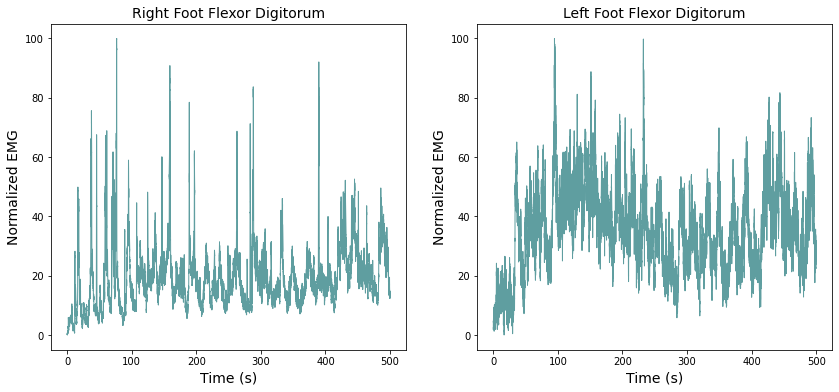

In [ ]:
Fs_EMG = 2000
N_EMG = len(sp_smooth_norm_emg[16]['RFOOTEXT']) # number of samples
T_EMG=(N_EMG-1)/Fs_EMG #duration
ts_EMG = np.linspace(0, T_EMG, N_EMG, endpoint=False)

#plt.plot(sp_smooth_norm_emg[16]['RFOOTEXT'])

fig = plt.figure(figsize=(14,6))
aa = plt.subplot(1, 2, 1)
plt.plot(ts_EMG, sp_smooth_norm_emg[16]['RFOOTEXT'], 'cadetblue', lw=1, label='_nolegend_')
plt.title('Right Foot Flexor Digitorum', fontsize=14)
plt.xlabel('Time (s)', fontsize=14);
plt.ylabel('Normalized EMG', fontsize=14);

#aa.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
bb = plt.subplot(1, 2, 2)
plt.plot(ts_EMG, sp_smooth_norm_emg[16]['LFOOTEXT'], 'cadetblue', lw=1, label='_nolegend_')
plt.title('Left Foot Flexor Digitorum', fontsize=14)
#bb.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
plt.xlabel('Time (s)', fontsize=14);
plt.ylabel('Normalized EMG', fontsize=14);

fig.savefig("EMG_exampledata.pdf", bbox_inches='tight')


### Splitting processed EMG data into conditions/songs

In [ ]:
hp_songorder = pd.read_csv('drive/My Drive/UiO RITMO/HeadphonesVSSpeakers/songorderhp.csv') #Reading csv with stimuli order used for each participant during headphones condition
hp_songorder.columns = ['Participant','1', '2', '3','4', '5', '6']
hp_songorder.set_index('Participant',inplace=True, drop=True)
hp_songorder

In [ ]:
sp_songorder = pd.read_csv('drive/My Drive/UiO RITMO/HeadphonesVSSpeakers/songordersp.csv') #Reading csv with stimuli order used for each participant during speakers condition
sp_songorder.columns = ['Participant','1', '2', '3','4', '5', '6']
sp_songorder.set_index('Participant',inplace=True, drop=True)

### Segmenting processed EMG data into music-silence segments

In [ ]:
def segments(songorder,data):
    #work in progress, works for emg data at 2000Hz, song duration used in 2018 headphones-speakers experiment
    #Silence 1 - 45?
    #Silence 2, 3, 4, 5, 6 - 30s
    #1 -  - 49s
    #2 -  - 48s
    #3 -  - 47s
    #4 -  - 48s
    #5 -  - 48s
    #6 -  - 48s
    #Silence 7 - 32s
    #Total duration of recording 500s
   
    
    start = {}
    segments = {}
    segments[1] = data[0:60000] #First silence segement: 30 seconds
    start[1] = 0
    start[2] = 60001
    song = 0
    
    while song <= len(songorder.columns)-1:
        for inicio in range (2,13,2):
            if songorder.iloc[0][song] == 1:
                        segments[inicio]=data[start[inicio]:start[inicio]+98000] #song1 49s
                        segments[inicio+1]=data[start[inicio]+98001:start[inicio]+98000+60000] #30s silence
                        start[inicio+2] = start[inicio]+98001+60000
                        song = song+1  
            elif songorder.iloc[0][song] == 2:
                        segments[inicio]=data[start[inicio]:start[inicio]+96000] #song2 48s
                        segments[inicio+1]=data[start[inicio]+96001:start[inicio]+96000+60000] #30s silence
                        start[inicio+2] = start[inicio]+96001+60000
                        song = song+1
            elif songorder.iloc[0][song] == 3:
                        segments[inicio]=data[start[inicio]:start[inicio]+94000] #song3 47s
                        segments[inicio+1]=data[start[inicio]+94001:start[inicio]+94000+60000] #30s silence
                        start[inicio+2] = start[inicio]+94001+60000
                        song = song+1
            elif songorder.iloc[0][song] == 4:
                        segments[inicio]=data[start[inicio]:start[inicio]+96000] #song4 48s
                        segments[inicio+1]=data[start[inicio]+96001:start[inicio]+96000+60000] #30s silence
                        start[inicio+2] = start[inicio]+96001+60000
                        song = song+1
            elif songorder.iloc[0][song] == 5:
                        segments[inicio]=data[start[inicio]:start[inicio]+96000] #song5 48s
                        segments[inicio+1]=data[start[inicio]+96001:start[inicio]+96000+60000] #30s silence
                        start[inicio+2] = start[inicio]+96001+60000
                        song = song+1
            elif songorder.iloc[0][song] == 6:
                        segments[inicio]=data[start[inicio]:start[inicio]+96000] #song6 48s
                        segments[inicio+1]=data[start[inicio]+96001:start[inicio]+96000+60000] #silence
                        start[inicio+2] = start[inicio]+96001+60000
                        song = song+1
    return segments

In [ ]:
hp_processed_emg_segm = {}  #Using segments function on headphones condition processed data for all participants
for i in list(hp_raw_emg):
    hp_processed_emg_segm[i] = segments(hp_songorder[i-1:i],hp_smooth_norm_emg[i])

In [ ]:
sp_processed_emg_segm = {}   #Using segments function on speakers condition processed data for all participants
for i in list(sp_raw_emg):
    sp_processed_emg_segm[i] = segments(sp_songorder[i-1:i],sp_smooth_norm_emg[i])

### Grouping segmented data by music/silence condition

In [ ]:
#Odd segments are silence, even segments are music
hp_processed_emg_segm_mus = {} #creating empty dictionaries for music and silence
hp_processed_emg_segm_sil = {}

for i in list(hp_raw_emg):
  hp_processed_emg_segm_mus[i] = {} #creating empty dictionary for each participant for both music and silence conditions
  hp_processed_emg_segm_sil[i] = {}
  k = 0
  
  for j in range (1,13,2):
    hp_processed_emg_segm_sil[i][k] = hp_processed_emg_segm[i][j] #filling each participant's dictionary with odd segments (silence)
    hp_processed_emg_segm_mus[i][k] = hp_processed_emg_segm[i][j+1] #filling each participant's dictionary with even segments (music)
    k=k+1
 
  

In [ ]:
#Same as above, for speakers condition
sp_processed_emg_segm_mus = {} #creating empty dictionaries for music and silence
sp_processed_emg_segm_sil = {}

for i in list(sp_raw_emg):
  sp_processed_emg_segm_mus[i] = {} #creating empty dictionary for each participant for both music and silence conditions
  sp_processed_emg_segm_sil[i] = {}
  kx = 0
  
  for j in range (1,13,2):
    sp_processed_emg_segm_sil[i][kx] = sp_processed_emg_segm[i][j] #filling each participant's dictionary with odd segments (silence)
    sp_processed_emg_segm_mus[i][kx] = sp_processed_emg_segm[i][j+1] #filling each participant's dictionary with even segments (music)
    kx=kx+1
 

In [ ]:
sp_processed_emg_segm_mus[3][0] #1st music segments participant 3, speakers condition

### Sorting music data by stimuli

In [ ]:
## Function to sort segments from each participant with corresponding stimuli
def sort_stimuli(songorder,data):
   
    sorted_stimuli = {}
    song = 0
    while song <= len(songorder.columns)-1:
        
            if songorder.iloc[0][song] == 1:
                       sorted_stimuli[1] = data[song]
                       song = song+1
            elif songorder.iloc[0][song] == 2:
                       sorted_stimuli[2] = data[song]
                       song = song+1
            elif songorder.iloc[0][song] == 3:
                       sorted_stimuli[3] = data[song]
                       song = song+1
            elif songorder.iloc[0][song] == 4:
                       sorted_stimuli[4] = data[song]
                       song = song+1
            elif songorder.iloc[0][song] == 5:
                       sorted_stimuli[5] = data[song]
                       song = song+1
            elif songorder.iloc[0][song] == 6:
                       sorted_stimuli[6] = data[song]
                       song = song+1
    return sorted_stimuli

In [ ]:
## Running stimuli-sorting function for all groups
hp_sorted_emg_mus = {}
for i in list(hp_raw_emg):  
    hp_sorted_emg_mus[i] = sort_stimuli(hp_songorder[i-1:i],hp_processed_emg_segm_mus[i])

In [ ]:
## Same as above, for speakers condition
sp_sorted_emg_mus = {}
for i in list(sp_raw_emg):  
    sp_sorted_emg_mus[i] = sort_stimuli(sp_songorder[i-1:i],sp_processed_emg_segm_mus[i])

In [ ]:
hp_sorted_emg_mus[3][2]

In [ ]:
#Mean Filtered EMG for each muscle for each participant for each music segment, heaphones condition
for i in list(hp_raw_emg): 
    
    for j in range(1,7):
        hp_sorted_emg_mus[i][j].loc['mean'] = hp_sorted_emg_mus[i][j].mean()        

In [ ]:
#Mean Filtered EMG for each muscle for each participant for each music segment, speakers condition
for i in list(sp_raw_emg): 
    
    for j in range(1,7):
        sp_sorted_emg_mus[i][j].loc['mean'] = sp_sorted_emg_mus[i][j].mean()   

In [ ]:
#Mean Filtered EMG for each muscle for each participant for each silence segment, heaphones condition
for i in list(hp_raw_emg): 
    
    for j in range(0,6):
        hp_processed_emg_segm_sil[i][j].loc['mean'] = hp_processed_emg_segm_sil[i][j].mean()        

In [ ]:
#Mean Filtered EMG for each muscle for each participant for each silence segment, speakers condition
for i in list(hp_raw_emg): 
    
    for j in range(0,6):
        hp_processed_emg_segm_sil[i][j].loc['mean'] = hp_processed_emg_segm_sil[i][j].mean() 

## Wii Balance Board Data Example
Data consist of 8 columns: Time Stamp, Top Left, Top Right, Bottom Left, Bottom Right, Sum, Centre of Gravity in X (CoG X), Centre of Gravity in Y (CoG Y).

In [ ]:
wii_board_example = pd.read_csv('path.csv', delim_whitespace=True, encoding='utf-8', low_memory=False, na_values='-1.#QNAN0', names=["Time Stamp", "Top Left", "Top Right", "Bottom Left", "Bottom Right", "Sum", "CoG X", "CoG Y"])


In [ ]:
wii_board_example = wii_board_example[:30000] #Fs approx 60Hz, 500s of recording

Fs = 60
N = len(wii_board_example) # number of samples
T=(N-1)/Fs #duration
ts = np.linspace(0, T, N, endpoint=False) 

wii_board_example


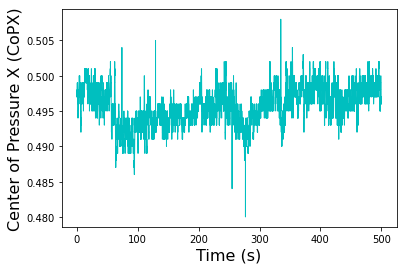

In [ ]:
plt.plot(ts, wii_board_example['CoG X'], 'c', lw=1, label='_nolegend_')
plt.xlabel('Time (s)', fontsize=16);
plt.ylabel('Center of Gravity (CoG)', fontsize=16);

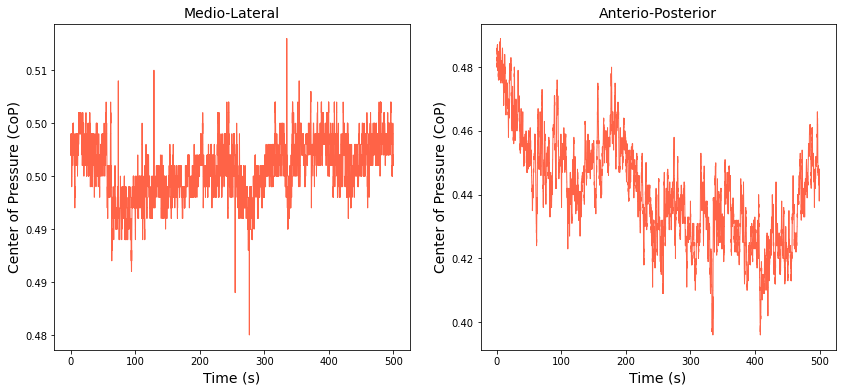

In [ ]:
from matplotlib.ticker import FormatStrFormatter

fig = plt.figure(figsize=(14,6))
aa = plt.subplot(1, 2, 1)
plt.plot(ts, wii_board_example['CoG X'], 'tomato', lw=1, label='_nolegend_')
plt.title('Medio-Lateral', fontsize=14)
plt.xlabel('Time (s)', fontsize=14);
plt.ylabel('Center of Gravity (CoG)', fontsize=14);

aa.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
bb = plt.subplot(1, 2, 2)
plt.plot(ts, wii_board_example['CoG Y'], 'tomato', lw=1, label='_nolegend_')
plt.title('Anterio-Posterior', fontsize=14)
bb.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
plt.xlabel('Time (s)', fontsize=14);
plt.ylabel('Center of Gravity (CoG)', fontsize=14);

fig.savefig("Wiiboard_exampledata.pdf", bbox_inches='tight')


## Sweetzpot Breathing Data Example

In [ ]:
breath_example_hp = pd.read_csv('path.csv', delim_whitespace=True, encoding='utf-8', low_memory=False, na_values='-1.#QNAN0', names = ['Data'])

breath_example_sp = pd.read_csv('path.csv', delim_whitespace=True, encoding='utf-8', low_memory=False, na_values='-1.#QNAN0', names = ['Data'])


In [ ]:
Fs_breath = 10
N_breath_hp = len(breath_example_hp) # number of samples
N_breath_sp = len(breath_example_sp) # number of samples

T_breath_hp =(N_breath_hp-1)/Fs_breath #duration
ts_breath_hp = np.linspace(0, T_breath_hp, N_breath_hp, endpoint=False)

T_breath_sp =(N_breath_sp-1)/Fs_breath #duration
ts_breath_sp = np.linspace(0, T_breath_sp, N_breath_sp, endpoint=False)

breath_example_hp =((breath_example_hp-breath_example_hp.min())/(breath_example_hp.max()-breath_example_hp.min()))*100

breath_example_sp =((breath_example_sp-breath_example_sp.min())/(breath_example_sp.max()-breath_example_sp.min()))*100



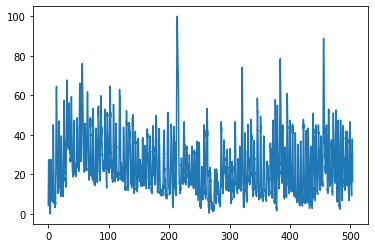

In [ ]:
plt.plot(ts_breath_hp,breath_example_hp)

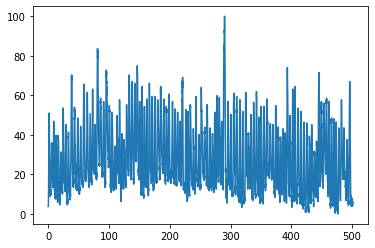

In [ ]:
plt.plot(ts_breath_sp,breath_example_sp)

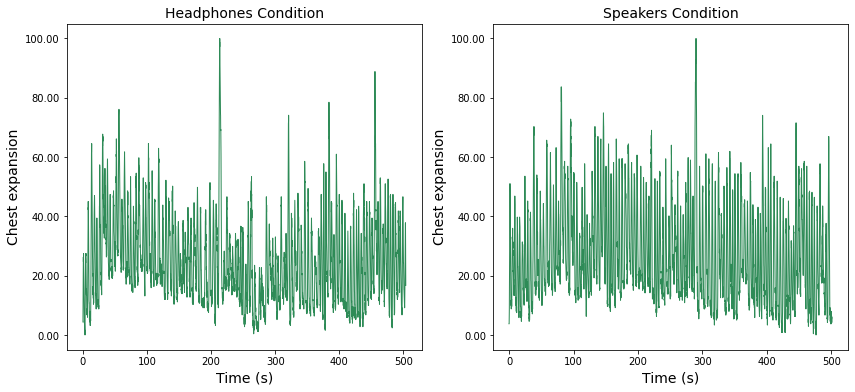

In [ ]:
from matplotlib.ticker import FormatStrFormatter

fig = plt.figure(figsize=(14,6))
aa = plt.subplot(1, 2, 1)
plt.plot(ts_breath_hp, breath_example_hp, 'seagreen', lw=1, label='_nolegend_')
plt.title('Headphones Condition', fontsize=14)
plt.xlabel('Time (s)', fontsize=14);
plt.ylabel('Chest expansion', fontsize=14);

aa.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
bb = plt.subplot(1, 2, 2)
plt.plot(ts_breath_sp, breath_example_sp, 'seagreen', lw=1, label='_nolegend_')
plt.title('Speakers Condition', fontsize=14)
bb.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
plt.xlabel('Time (s)', fontsize=14);
plt.ylabel('Chest expansion', fontsize=14);

fig.savefig("breath_exampledata.pdf", bbox_inches='tight')